# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
!pwd

/p/Users/andy/Dropbox/_UDACITY/Reinforcement Learning/TennisCoop2


In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
print(brain)

Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
runSample=False  #set to true to run sample/take random actions in environment

In [8]:

if (runSample): 
    for i in range(1, 6):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [9]:
if (runSample): 
    env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## Implement MADDPG policy

### Setup Parameters

This uses a basic structure 'Parameters' to encapsalate all common parameters

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Parameters import Parameters

p=Parameters()
p.set_defaults()
p.BATCH_SIZE=256
p.STEPS_BEFORE_LEARN=5
p.NUM_LEARN_STEPS=25
p.STATE_SIZE=state_size
p.ACTION_SIZE=action_size
p.NUM_AGENTS=num_agents
p.BUFFER_SIZE=int(1.0e5)
p.LR_ACTOR=.0001
p.LR_CRITIC=.001
p.TAU = 0.05
p.WEIGHT_DECAY=0
p.EPSILON=.99
p.EPSILON_DECAY=.9998
p.GAMMA = 0.95
p.GAMMA_DECAY = 1.0001
p.NOISE_SIGMA=.25
p.DEVICE= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = p.DEVICE

print(p)

Parameters:
STATE_SIZE(0):24
ACTION_SIZE(0):2
NUM_AGENTS(0):2
RANDOM_SEED(1):1
BUFFER_SIZE(ie5):100000
BATCH_SIZE(512):256
STEPS_BEFORE_LEARN(15) :5
NUM_LEARN_STEPS(10):25
GAMMA(.99):0.95
GAMMA_MAX(.99):0.99
GAMMA_DECAY(1.001):1.0001
TAU Size(1e-3):0.05
LR_ACTOR(ie-4):0.0001
LR_CRITIC(1e-5):0.001
WEIGHT_DECAY(0):0
DEVICE(cpu):cuda:0
EPSILON(1.0):0.99
EPSILON_MIN(.1) :0.1
EPSILON_DECAY(.995) :0.9998
NOISE_SIGMA(0.2):0.25



In [12]:
from maddpg_agent import DDPGAgent,MADDPGAgent
agent = MADDPGAgent(p)

### savePrintScores()

prints progresss and saves network

- in parameters:
    - i_episode     :   current episode
    - save_interval :   how often to save network
    - score_average :   current average of scores
    - scores        :   current scores
    - p             :   parameter object
    

In [13]:
solved=False

def save_print_scores(i_episode,save_interval,score_average,scores,max_score, p):
    global solved
    if score_average<=0.5:
        print('\r         Episode {}, Average Score: {:.2f}, Std Dev: {:.2f}, Eps: {:.2f}, gam: {:.2f}'\
              .format(i_episode, score_average, np.std(scores), p.EPSILON, p.GAMMA), end="\n")        

    if i_episode % save_interval==0 and not solved:
        for i in range(p.NUM_AGENTS):
            torch.save(agent.agents[i].actor_local.state_dict(), 'checkpoints\checkpoint_actor'+str(i)+'_opt.pth')
        print("\r saved")

    if score_average > 0.5:
        solved=True
        print('\r*solved* Episode {}, Average Score: {:.2f}, Std Dev: {:.2f}, Eps: {:.2f}, gam: {:.2f}'\
              .format(i_episode, score_average, np.std(scores), p.EPSILON, p.GAMMA), end="\n")        
        if score_average == max_score:
            for i in range(p.NUM_AGENTS):
                torch.save(agent.agents[i].actor_local.state_dict(), 'checkpoints\optimum_checkpoint_actor'+str(i)+'_opt.pth')
                print("\r opt saved")


### updateLrSteps()

updates Learning Rate and number of steps

- in parameters:
    - i_episode     :   current episode
    - p             :   parameter object
    

In [14]:
def updateLrSteps(i_episode,score_average):
    if i_episode == 1000:
        p.STEPS_BEFORE_LEARN=40
        p.NUM_LEARN_STEPS=30
        agent.lr_step()
    if i_episode  == 3000:
        p.STEPS_BEFORE_LEARN=50
        p.NUM_LEARN_STEPS=20
    if score_average > 0.5:
        p.STEPS_BEFORE_LEARN=10
        p.NUM_LEARN_STEPS=10

## Train Agents

##### (Note:You can safely Interupt Kernel to stop early)

In [16]:
from collections import deque
import math

average_period=100
scores_deque = deque(maxlen=average_period)
scores_global = []
average_global = []

p.STEPS_BEFORE_LEARN=5
p.NUM_LEARN_STEPS=25


def ddpg(n_episodes=10000,save_interval=100):
    try:
        max_score=0
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
            states = env_info.vector_observations                  # get the current state (for each agent)
            prev_states=states
            agent.reset()
            scores = np.zeros(num_agents)                          # initialize the score (for each agent)
            score_average = 0
            while(True):
                actions = agent.act(prev_states,states, add_noise=True)
                env_info = env.step(actions)[brain_name]           # send all actions to the environment
                next_states = env_info.vector_observations         # get next state (for each agent)
                rewards = env_info.rewards                         # get reward (for each agent)
                dones = env_info.local_done                        # see if any episode finished
                agent.step(prev_states, states, actions, rewards, next_states, dones) # take a step using agent
                prev_states = states
                states = next_states                               # roll over states to next time step
                scores += rewards                                  # update the score (for each agent)
                if np.any(dones):                                  # exit loop if episode finished
                    break

            score = np.mean(scores)
            scores_deque.append(score)
            score_average = np.mean(scores_deque)
            scores_global.append(score)
            average_global.append(score_average)
            if score_average>max_score:
                max_score=score_average
            np.save("scores",scores)
            np.save("scores_global",scores_global)
            np.save("average_global",average_global)
            #updateLrSteps(i_episode,score_average)

            p.EPSILON = max(p.EPSILON * p.EPSILON_DECAY,p.EPSILON_MIN)
            p.GAMMA = min(p.GAMMA_MAX,p.GAMMA*p.GAMMA_DECAY)

            save_print_scores(i_episode,save_interval,score_average,scores,max_score,p)
 
    except (KeyboardInterrupt,SystemExit):
        print("exiting")
        save_print_scores(i_episode,save_interval,score_average,scores,max_score,p)
    return scores_global, average_global

scores, averages = ddpg()


         Episode 1, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 2, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 3, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 4, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 5, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 6, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 7, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 8, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 9, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 10, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 11, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 12, Average Score: -0.00, Std Dev: 0.00, Eps: 0.99, gam: 0.95
         Episode 13, Average Score: -0.00, Std Dev: 0.06, Eps

         Episode 105, Average Score: -0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 106, Average Score: -0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 107, Average Score: 0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 108, Average Score: 0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 109, Average Score: 0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 110, Average Score: 0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 111, Average Score: 0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 112, Average Score: 0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 113, Average Score: 0.00, Std Dev: 0.00, Eps: 0.97, gam: 0.96
         Episode 114, Average Score: 0.00, Std Dev: 0.06, Eps: 0.97, gam: 0.96
         Episode 115, Average Score: 0.00, Std Dev: 0.05, Eps: 0.97, gam: 0.96
         Episode 116, Average Score: 0.00, Std Dev: 0.06, Eps: 0.97, gam: 0.96
         Episode 117, Average Score: 0.00, Std Dev

         Episode 209, Average Score: 0.13, Std Dev: 0.00, Eps: 0.95, gam: 0.97
         Episode 210, Average Score: 0.13, Std Dev: 0.06, Eps: 0.95, gam: 0.97
         Episode 211, Average Score: 0.13, Std Dev: 0.06, Eps: 0.95, gam: 0.97
         Episode 212, Average Score: 0.14, Std Dev: 0.00, Eps: 0.95, gam: 0.97
         Episode 213, Average Score: 0.16, Std Dev: 0.05, Eps: 0.95, gam: 0.97
         Episode 214, Average Score: 0.18, Std Dev: 0.00, Eps: 0.95, gam: 0.97
         Episode 215, Average Score: 0.19, Std Dev: 0.00, Eps: 0.95, gam: 0.97
         Episode 216, Average Score: 0.19, Std Dev: 0.00, Eps: 0.95, gam: 0.97
         Episode 217, Average Score: 0.19, Std Dev: 0.05, Eps: 0.95, gam: 0.97
         Episode 218, Average Score: 0.19, Std Dev: 0.05, Eps: 0.95, gam: 0.97
         Episode 219, Average Score: 0.19, Std Dev: 0.06, Eps: 0.95, gam: 0.97
         Episode 220, Average Score: 0.20, Std Dev: 0.00, Eps: 0.95, gam: 0.97
         Episode 221, Average Score: 0.23, Std Dev: 

*solved* Episode 305, Average Score: 0.66, Std Dev: 0.00, Eps: 0.93, gam: 0.98
*solved* Episode 306, Average Score: 0.66, Std Dev: 0.05, Eps: 0.93, gam: 0.98
*solved* Episode 307, Average Score: 0.66, Std Dev: 0.06, Eps: 0.93, gam: 0.98
 opt saved
 opt saved
*solved* Episode 308, Average Score: 0.66, Std Dev: 0.06, Eps: 0.93, gam: 0.98
 opt saved
 opt saved
*solved* Episode 309, Average Score: 0.67, Std Dev: 0.06, Eps: 0.93, gam: 0.98
 opt saved
 opt saved
*solved* Episode 310, Average Score: 0.67, Std Dev: 0.00, Eps: 0.93, gam: 0.98
 opt saved
 opt saved
*solved* Episode 311, Average Score: 0.68, Std Dev: 0.00, Eps: 0.93, gam: 0.98
 opt saved
 opt saved
*solved* Episode 312, Average Score: 0.69, Std Dev: 0.06, Eps: 0.93, gam: 0.98
 opt saved
 opt saved
*solved* Episode 313, Average Score: 0.68, Std Dev: 0.00, Eps: 0.93, gam: 0.98
*solved* Episode 314, Average Score: 0.66, Std Dev: 0.00, Eps: 0.93, gam: 0.98
*solved* Episode 315, Average Score: 0.66, Std Dev: 0.06, Eps: 0.93, gam: 0.98

*solved* Episode 408, Average Score: 0.54, Std Dev: 0.06, Eps: 0.91, gam: 0.99
*solved* Episode 409, Average Score: 0.54, Std Dev: 0.00, Eps: 0.91, gam: 0.99
*solved* Episode 410, Average Score: 0.54, Std Dev: 0.00, Eps: 0.91, gam: 0.99
*solved* Episode 411, Average Score: 0.52, Std Dev: 0.06, Eps: 0.91, gam: 0.99
*solved* Episode 412, Average Score: 0.51, Std Dev: 0.06, Eps: 0.91, gam: 0.99
*solved* Episode 413, Average Score: 0.52, Std Dev: 0.05, Eps: 0.91, gam: 0.99
*solved* Episode 414, Average Score: 0.53, Std Dev: 0.06, Eps: 0.91, gam: 0.99
*solved* Episode 415, Average Score: 0.53, Std Dev: 0.00, Eps: 0.91, gam: 0.99
*solved* Episode 416, Average Score: 0.53, Std Dev: 0.06, Eps: 0.91, gam: 0.99
*solved* Episode 417, Average Score: 0.53, Std Dev: 0.00, Eps: 0.91, gam: 0.99
*solved* Episode 418, Average Score: 0.53, Std Dev: 0.00, Eps: 0.91, gam: 0.99
*solved* Episode 419, Average Score: 0.53, Std Dev: 0.00, Eps: 0.91, gam: 0.99
*solved* Episode 420, Average Score: 0.54, Std Dev: 

*solved* Episode 509, Average Score: 0.84, Std Dev: 0.05, Eps: 0.89, gam: 0.99
 opt saved
 opt saved
*solved* Episode 510, Average Score: 0.84, Std Dev: 0.00, Eps: 0.89, gam: 0.99
*solved* Episode 511, Average Score: 0.86, Std Dev: 0.05, Eps: 0.89, gam: 0.99
 opt saved
 opt saved
*solved* Episode 512, Average Score: 0.87, Std Dev: 0.05, Eps: 0.89, gam: 0.99
 opt saved
 opt saved
*solved* Episode 513, Average Score: 0.85, Std Dev: 0.06, Eps: 0.89, gam: 0.99
*solved* Episode 514, Average Score: 0.85, Std Dev: 0.05, Eps: 0.89, gam: 0.99
*solved* Episode 515, Average Score: 0.85, Std Dev: 0.06, Eps: 0.89, gam: 0.99
*solved* Episode 516, Average Score: 0.84, Std Dev: 0.00, Eps: 0.89, gam: 0.99
*solved* Episode 517, Average Score: 0.84, Std Dev: 0.00, Eps: 0.89, gam: 0.99
*solved* Episode 518, Average Score: 0.85, Std Dev: 0.06, Eps: 0.89, gam: 0.99
*solved* Episode 519, Average Score: 0.85, Std Dev: 0.06, Eps: 0.89, gam: 0.99
*solved* Episode 520, Average Score: 0.83, Std Dev: 0.00, Eps: 0.

*solved* Episode 612, Average Score: 0.65, Std Dev: 0.06, Eps: 0.88, gam: 0.99
*solved* Episode 613, Average Score: 0.65, Std Dev: 0.00, Eps: 0.88, gam: 0.99
*solved* Episode 614, Average Score: 0.64, Std Dev: 0.06, Eps: 0.88, gam: 0.99
*solved* Episode 615, Average Score: 0.64, Std Dev: 0.05, Eps: 0.88, gam: 0.99
*solved* Episode 616, Average Score: 0.63, Std Dev: 0.06, Eps: 0.88, gam: 0.99
*solved* Episode 617, Average Score: 0.63, Std Dev: 0.00, Eps: 0.88, gam: 0.99
*solved* Episode 618, Average Score: 0.63, Std Dev: 0.06, Eps: 0.87, gam: 0.99
*solved* Episode 619, Average Score: 0.65, Std Dev: 0.05, Eps: 0.87, gam: 0.99
*solved* Episode 620, Average Score: 0.67, Std Dev: 0.00, Eps: 0.87, gam: 0.99
*solved* Episode 621, Average Score: 0.70, Std Dev: 0.00, Eps: 0.87, gam: 0.99
*solved* Episode 622, Average Score: 0.72, Std Dev: 0.06, Eps: 0.87, gam: 0.99
*solved* Episode 623, Average Score: 0.73, Std Dev: 0.06, Eps: 0.87, gam: 0.99
*solved* Episode 624, Average Score: 0.75, Std Dev: 

## Save last Trained Agents (optional)

In [18]:
torch.save(agent.agents[0].actor_local.state_dict(), 'checkpoints\manual_checkpoint_actor1_opt.pth')
torch.save(agent.agents[1].actor_local.state_dict(), 'checkpoints\manual_checkpoint_actor2_opt.pth')

## Plot Results of Training Run

C:\Users\andy\AppData\Local\conda\conda\envs\deeprl\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\andy\AppData\Local\conda\conda\envs\deeprl\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\andy\AppData\Local\conda\conda\envs\deeprl\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


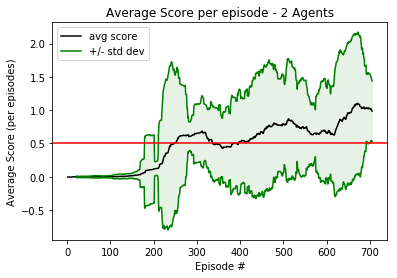

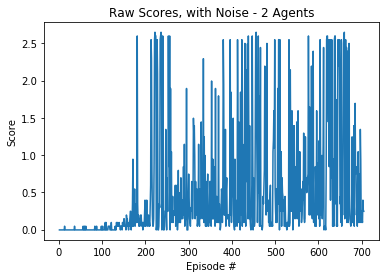

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


stdm=[average_global[i]-np.std(scores_global[i-20:i+3]) for i in range(len(scores_global))]
stdp=[average_global[i]+np.std(scores_global[i-20:i+3]) for i in range(len(scores_global))]

plt.plot(np.arange(1, len(scores_global)+1), average_global,color='black',label='avg score')
plt.plot(np.arange(1, len(scores_global)+1), stdm,color='green',label='+/- std dev')
plt.plot(np.arange(1, len(scores_global)+1), stdp,color='green')
plt.fill_between(range(len(scores_global)),
                 stdm,
                 stdp,
                 color='green',alpha=0.1,interpolate=True)
plt.title("Average Score per episode - 2 Agents")
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylabel('Average Score (per episodes)')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

fig = plt.figure()
plt.title("Raw Scores, with Noise - 2 Agents")
plt.plot(np.arange(1, len(scores_global)+1), scores_global)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Load and Run Optimal trained agents
##### (Note:You can safely Interupt Kernel to stop early
##### and if your not training, run all cells up to, and not including TrainAgent above)

In [15]:

for i in range(p.NUM_AGENTS):
    agent.agents[i].actor_local.load_state_dict(torch.load('checkpoints\optimum_checkpoint_actor'+str(i)+'_opt.pth'))
print("loaded optimal network")
                


loaded optimal network


In [17]:
from collections import deque
import time

average_period=100
rscores_deque = deque(maxlen=average_period)
rscores_global = []
raverage_global = []

def run_agent(n_episodes=100):
    try:
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
            states = env_info.vector_observations                  # get the current state (for each agent)
            prev_states=states
            agent.reset()
            rscores = np.zeros(num_agents)                          # initialize the score (for each agent)
            time.sleep(3)

            while(True):
                actions = agent.act(prev_states,states, add_noise=False)
                env_info = env.step(actions)[brain_name]           # send all actions to the environment
                next_states = env_info.vector_observations         # get next state (for each agent)
                rewards = env_info.rewards                         # get reward (for each agent)
                dones = env_info.local_done                        # see if any episode finished
                prev_states = states
                states = next_states                               # roll over states to next time step
                rscores += rewards                                  # update the score (for each agent)            
                if np.any(dones):                                  # exit loop if episode finished
                    break

            rscore = np.mean(rscores)
            rscores_deque.append(rscore)
            rscore_average = np.mean(rscores_deque)
            rscores_global.append(rscore)
            raverage_global.append(rscore_average)
            print("run score=",rscore," average=",rscore_average)
    except (KeyboardInterrupt,SystemExit):
         print("exiting...")
        
        
    return rscores_global,raverage_global

rscores,raverage=run_agent()
print("rscore=",rscores,raverage)


run score= 0.4950000075623393  average= 0.4950000075623393
run score= 0.245000003837049  average= 0.37000000569969416
run score= 0.6950000114738941  average= 0.4783333409577608
run score= 0.04500000085681677  average= 0.3700000059325248
run score= 1.2950000194832683  average= 0.5550000086426735
run score= 1.2950000194832683  average= 0.6783333437827727
run score= 0.9950000150129199  average= 0.7235714396727937
run score= 0.6450000097975135  average= 0.7137500109383836
exiting...
rscore= [0.4950000075623393, 0.245000003837049, 0.6950000114738941, 0.04500000085681677, 1.2950000194832683, 1.2950000194832683, 0.9950000150129199, 0.6450000097975135] [0.4950000075623393, 0.37000000569969416, 0.4783333409577608, 0.3700000059325248, 0.5550000086426735, 0.6783333437827727, 0.7235714396727937, 0.7137500109383836]


## Plot Results of Trained Run

C:\Users\andy\AppData\Local\conda\conda\envs\deeprl\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\andy\AppData\Local\conda\conda\envs\deeprl\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\andy\AppData\Local\conda\conda\envs\deeprl\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


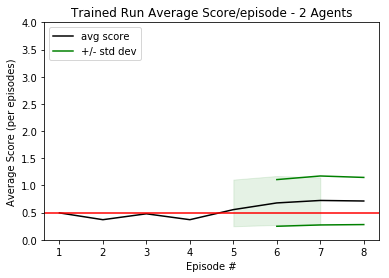

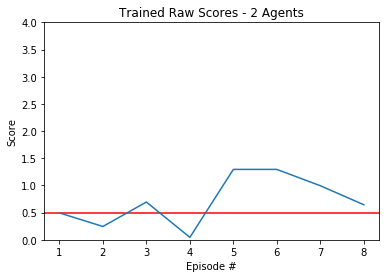

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


stdm=[raverage_global[i]-np.std(rscores_global[i-5:i+3]) for i in range(len(rscores_global))]
stdp=[raverage_global[i]+np.std(rscores_global[i-5:i+3]) for i in range(len(rscores_global))]

plt.plot(np.arange(1, len(rscores_global)+1), raverage_global,color='black',label='avg score')
plt.plot(np.arange(1, len(rscores_global)+1), stdm,color='green',label='+/- std dev')
plt.plot(np.arange(1, len(rscores_global)+1), stdp,color='green')
plt.ylim(0, 4)
plt.fill_between(range(len(rscores_global)),
                 stdm,
                 stdp,
                 color='green',alpha=0.1,interpolate=True)
plt.title("Trained Run Average Score/episode - 2 Agents")
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylabel('Average Score (per episodes)')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

fig = plt.figure()
plt.ylim(0, 4)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.title("Trained Raw Scores - 2 Agents")
plt.plot(np.arange(1, len(rscores_global)+1), rscores_global)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()